<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


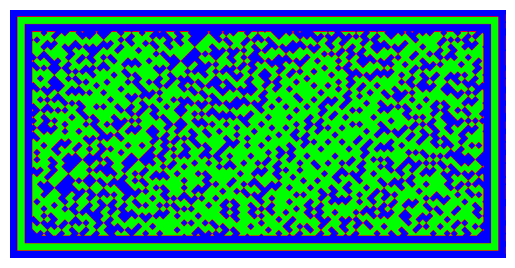

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
def loss_batch(model, loss_func, xb, yb, optimizer=None):
    yb = torch.argmax(yb, dim=1)

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.long())

    return loss.item(), corrects, len(xb)

In [8]:
import matplotlib.pyplot as plt

def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(epochs)):
        # Training process
        model.train()
        running_loss = 0.0
        running_corrects = 0
        sample_num = 0

        for xb, yb in train_dl:
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, optimizer)
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num += nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in valid_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double() / sample_num

        # Testing process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in test_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            test_loss = running_loss / sample_num
            test_acc = running_corrects.double() / sample_num

        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}', f'ACC: {train_acc:.4f} ', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}', f'VAL-ACC: {val_acc:.4f} ', end=' ')
        print(f'TEST-LOSS: {test_loss:.4f}', f'TEST-ACC: {test_acc:.4f} ', end='\n')

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot losses and accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, 'r:', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'g:', label='Validation Loss')
    plt.plot(range(1, epochs+1), test_losses, 'b:', label='Test Loss')
    plt.plot(range(1, epochs+1), train_accs, 'r', label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accs, 'g', label='Validation Accuracy')
    plt.plot(range(1, epochs+1), test_accs, 'b', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.title('Loss and Accuracy vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2),
    )

In [10]:
batch_size = 64
train_dl, valid_dl = get_data(train_dataset, val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2)

In [11]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [12]:
model = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

  5%|▌         | 1/20 [00:10<03:21, 10.61s/it]

EPOCH: 01/20 LOSS: 1.0736 ACC: 0.4119  VAL-LOSS: 0.9629 VAL-ACC: 0.5260  TEST-LOSS: 0.9494 TEST-ACC: 0.5420 


 10%|█         | 2/20 [00:21<03:14, 10.82s/it]

EPOCH: 02/20 LOSS: 0.8176 ACC: 0.6112  VAL-LOSS: 0.6101 VAL-ACC: 0.7460  TEST-LOSS: 0.5996 TEST-ACC: 0.7440 


 15%|█▌        | 3/20 [00:32<03:05, 10.93s/it]

EPOCH: 03/20 LOSS: 0.5153 ACC: 0.7721  VAL-LOSS: 0.2871 VAL-ACC: 0.8935  TEST-LOSS: 0.2737 TEST-ACC: 0.8880 


 20%|██        | 4/20 [00:43<02:54, 10.93s/it]

EPOCH: 04/20 LOSS: 0.3173 ACC: 0.8697  VAL-LOSS: 0.1848 VAL-ACC: 0.9290  TEST-LOSS: 0.1780 TEST-ACC: 0.9220 


 25%|██▌       | 5/20 [00:54<02:43, 10.92s/it]

EPOCH: 05/20 LOSS: 0.2171 ACC: 0.9133  VAL-LOSS: 0.1243 VAL-ACC: 0.9545  TEST-LOSS: 0.1174 TEST-ACC: 0.9560 


 30%|███       | 6/20 [01:05<02:32, 10.93s/it]

EPOCH: 06/20 LOSS: 0.1805 ACC: 0.9285  VAL-LOSS: 0.1272 VAL-ACC: 0.9510  TEST-LOSS: 0.1053 TEST-ACC: 0.9580 


 35%|███▌      | 7/20 [01:16<02:22, 10.96s/it]

EPOCH: 07/20 LOSS: 0.1469 ACC: 0.9429  VAL-LOSS: 0.0778 VAL-ACC: 0.9770  TEST-LOSS: 0.0815 TEST-ACC: 0.9720 


 40%|████      | 8/20 [01:26<02:09, 10.81s/it]

EPOCH: 08/20 LOSS: 0.1311 ACC: 0.9495  VAL-LOSS: 0.0851 VAL-ACC: 0.9675  TEST-LOSS: 0.0644 TEST-ACC: 0.9760 


 45%|████▌     | 9/20 [01:37<01:57, 10.71s/it]

EPOCH: 09/20 LOSS: 0.1183 ACC: 0.9547  VAL-LOSS: 0.0666 VAL-ACC: 0.9770  TEST-LOSS: 0.0680 TEST-ACC: 0.9880 


 50%|█████     | 10/20 [01:47<01:46, 10.65s/it]

EPOCH: 10/20 LOSS: 0.1149 ACC: 0.9565  VAL-LOSS: 0.0586 VAL-ACC: 0.9805  TEST-LOSS: 0.0478 TEST-ACC: 0.9840 


 55%|█████▌    | 11/20 [01:58<01:36, 10.69s/it]

EPOCH: 11/20 LOSS: 0.0929 ACC: 0.9636  VAL-LOSS: 0.0937 VAL-ACC: 0.9580  TEST-LOSS: 0.0760 TEST-ACC: 0.9720 


 60%|██████    | 12/20 [02:09<01:25, 10.69s/it]

EPOCH: 12/20 LOSS: 0.0842 ACC: 0.9691  VAL-LOSS: 0.0550 VAL-ACC: 0.9805  TEST-LOSS: 0.0567 TEST-ACC: 0.9760 


 65%|██████▌   | 13/20 [02:19<01:14, 10.64s/it]

EPOCH: 13/20 LOSS: 0.0812 ACC: 0.9685  VAL-LOSS: 0.0412 VAL-ACC: 0.9875  TEST-LOSS: 0.0405 TEST-ACC: 0.9820 


 70%|███████   | 14/20 [02:30<01:03, 10.60s/it]

EPOCH: 14/20 LOSS: 0.0805 ACC: 0.9699  VAL-LOSS: 0.0725 VAL-ACC: 0.9780  TEST-LOSS: 0.0593 TEST-ACC: 0.9820 


 75%|███████▌  | 15/20 [02:40<00:52, 10.57s/it]

EPOCH: 15/20 LOSS: 0.0797 ACC: 0.9693  VAL-LOSS: 0.0349 VAL-ACC: 0.9855  TEST-LOSS: 0.0351 TEST-ACC: 0.9920 


 80%|████████  | 16/20 [02:51<00:42, 10.55s/it]

EPOCH: 16/20 LOSS: 0.0633 ACC: 0.9751  VAL-LOSS: 0.0302 VAL-ACC: 0.9895  TEST-LOSS: 0.0346 TEST-ACC: 0.9880 


 85%|████████▌ | 17/20 [03:02<00:31, 10.56s/it]

EPOCH: 17/20 LOSS: 0.0596 ACC: 0.9787  VAL-LOSS: 0.0604 VAL-ACC: 0.9745  TEST-LOSS: 0.0508 TEST-ACC: 0.9820 


 90%|█████████ | 18/20 [03:13<00:21, 10.71s/it]

EPOCH: 18/20 LOSS: 0.0667 ACC: 0.9765  VAL-LOSS: 0.0535 VAL-ACC: 0.9825  TEST-LOSS: 0.0402 TEST-ACC: 0.9840 


 95%|█████████▌| 19/20 [03:23<00:10, 10.65s/it]

EPOCH: 19/20 LOSS: 0.0606 ACC: 0.9788  VAL-LOSS: 0.0260 VAL-ACC: 0.9915  TEST-LOSS: 0.0260 TEST-ACC: 0.9880 


100%|██████████| 20/20 [03:34<00:00, 10.71s/it]

EPOCH: 20/20 LOSS: 0.0725 ACC: 0.9756  VAL-LOSS: 0.0471 VAL-ACC: 0.9795  TEST-LOSS: 0.0390 TEST-ACC: 0.9840 


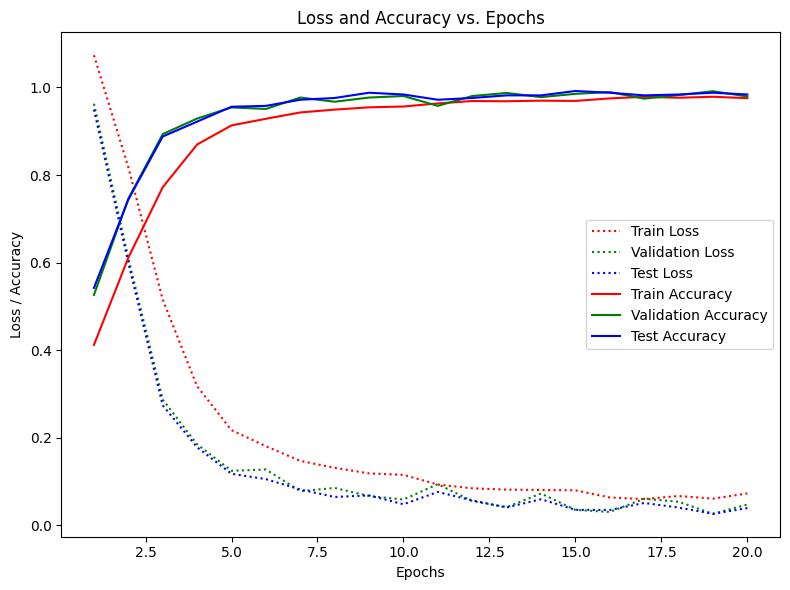

In [13]:
from torch import optim

lr = 0.06
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 20
loss_func = F.cross_entropy

fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl)

## Task 1: Question 5d

### Experiment 1
In this experiment, we change the number of convolutional filters in the model architecture. Convolutional filters are responsible for capturing different patterns and features from the input data. By altering the number of filters, we can assess the effect on the model's performance.

  5%|▌         | 1/20 [00:09<02:51,  9.00s/it]

EPOCH: 01/20 LOSS: 1.0443 ACC: 0.4312  VAL-LOSS: 0.8000 VAL-ACC: 0.6230  TEST-LOSS: 0.7818 TEST-ACC: 0.6220 


 10%|█         | 2/20 [00:17<02:41,  8.98s/it]

EPOCH: 02/20 LOSS: 0.6845 ACC: 0.6932  VAL-LOSS: 0.4510 VAL-ACC: 0.8125  TEST-LOSS: 0.4613 TEST-ACC: 0.8140 


 15%|█▌        | 3/20 [00:26<02:32,  8.98s/it]

EPOCH: 03/20 LOSS: 0.4143 ACC: 0.8307  VAL-LOSS: 0.2496 VAL-ACC: 0.9010  TEST-LOSS: 0.2627 TEST-ACC: 0.9060 


 20%|██        | 4/20 [00:35<02:23,  8.99s/it]

EPOCH: 04/20 LOSS: 0.2978 ACC: 0.8815  VAL-LOSS: 0.1891 VAL-ACC: 0.9365  TEST-LOSS: 0.2015 TEST-ACC: 0.9380 


 25%|██▌       | 5/20 [00:44<02:14,  8.99s/it]

EPOCH: 05/20 LOSS: 0.2462 ACC: 0.9060  VAL-LOSS: 0.1513 VAL-ACC: 0.9490  TEST-LOSS: 0.1456 TEST-ACC: 0.9480 


 30%|███       | 6/20 [00:53<02:05,  8.99s/it]

EPOCH: 06/20 LOSS: 0.2182 ACC: 0.9139  VAL-LOSS: 0.1153 VAL-ACC: 0.9625  TEST-LOSS: 0.1333 TEST-ACC: 0.9460 


 35%|███▌      | 7/20 [01:02<01:56,  8.99s/it]

EPOCH: 07/20 LOSS: 0.1732 ACC: 0.9329  VAL-LOSS: 0.0935 VAL-ACC: 0.9690  TEST-LOSS: 0.1072 TEST-ACC: 0.9580 


 40%|████      | 8/20 [01:11<01:47,  9.00s/it]

EPOCH: 08/20 LOSS: 0.1619 ACC: 0.9375  VAL-LOSS: 0.1173 VAL-ACC: 0.9535  TEST-LOSS: 0.1344 TEST-ACC: 0.9380 


 45%|████▌     | 9/20 [01:20<01:39,  9.01s/it]

EPOCH: 09/20 LOSS: 0.1409 ACC: 0.9471  VAL-LOSS: 0.0827 VAL-ACC: 0.9725  TEST-LOSS: 0.0871 TEST-ACC: 0.9660 


 50%|█████     | 10/20 [01:30<01:30,  9.03s/it]

EPOCH: 10/20 LOSS: 0.1403 ACC: 0.9469  VAL-LOSS: 0.0816 VAL-ACC: 0.9735  TEST-LOSS: 0.1036 TEST-ACC: 0.9600 


 55%|█████▌    | 11/20 [01:39<01:21,  9.06s/it]

EPOCH: 11/20 LOSS: 0.1187 ACC: 0.9553  VAL-LOSS: 0.0880 VAL-ACC: 0.9675  TEST-LOSS: 0.1055 TEST-ACC: 0.9660 


 60%|██████    | 12/20 [01:48<01:12,  9.06s/it]

EPOCH: 12/20 LOSS: 0.1205 ACC: 0.9549  VAL-LOSS: 0.1067 VAL-ACC: 0.9600  TEST-LOSS: 0.1187 TEST-ACC: 0.9580 


 65%|██████▌   | 13/20 [01:57<01:03,  9.10s/it]

EPOCH: 13/20 LOSS: 0.1121 ACC: 0.9564  VAL-LOSS: 0.0590 VAL-ACC: 0.9750  TEST-LOSS: 0.0753 TEST-ACC: 0.9740 


 70%|███████   | 14/20 [02:06<00:54,  9.08s/it]

EPOCH: 14/20 LOSS: 0.0977 ACC: 0.9632  VAL-LOSS: 0.0575 VAL-ACC: 0.9800  TEST-LOSS: 0.0781 TEST-ACC: 0.9680 


 75%|███████▌  | 15/20 [02:15<00:45,  9.07s/it]

EPOCH: 15/20 LOSS: 0.0983 ACC: 0.9657  VAL-LOSS: 0.0831 VAL-ACC: 0.9700  TEST-LOSS: 0.0811 TEST-ACC: 0.9700 


 80%|████████  | 16/20 [02:24<00:36,  9.17s/it]

EPOCH: 16/20 LOSS: 0.0944 ACC: 0.9643  VAL-LOSS: 0.0682 VAL-ACC: 0.9755  TEST-LOSS: 0.0627 TEST-ACC: 0.9680 


 85%|████████▌ | 17/20 [02:34<00:27,  9.16s/it]

EPOCH: 17/20 LOSS: 0.0950 ACC: 0.9633  VAL-LOSS: 0.0743 VAL-ACC: 0.9665  TEST-LOSS: 0.0715 TEST-ACC: 0.9700 


 90%|█████████ | 18/20 [02:43<00:18,  9.31s/it]

EPOCH: 18/20 LOSS: 0.0868 ACC: 0.9679  VAL-LOSS: 0.0538 VAL-ACC: 0.9785  TEST-LOSS: 0.0661 TEST-ACC: 0.9700 


 95%|█████████▌| 19/20 [02:53<00:09,  9.41s/it]

EPOCH: 19/20 LOSS: 0.0782 ACC: 0.9721  VAL-LOSS: 0.0600 VAL-ACC: 0.9770  TEST-LOSS: 0.0808 TEST-ACC: 0.9700 


100%|██████████| 20/20 [03:02<00:00,  9.14s/it]

EPOCH: 20/20 LOSS: 0.0700 ACC: 0.9747  VAL-LOSS: 0.0554 VAL-ACC: 0.9775  TEST-LOSS: 0.0791 TEST-ACC: 0.9740 


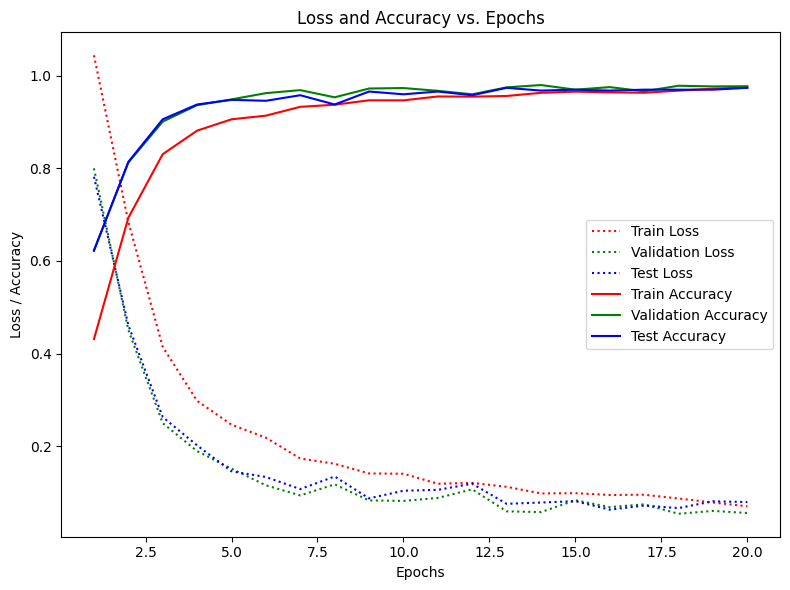

In [14]:
# Experiment 1: Change the Number of Convolutional Filters
model_exp1 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False), # Change the number of filters to 16
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16), # Adjust the batch normalization layer accordingly
    nn.Dropout(0.2),
    nn.Conv2d(16, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp1, loss_func, optimizer_exp1, train_dl, valid_dl, test_dl)

### Experiment 2
In this experiment, we change the activation function used in the model architecture. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and make non-linear predictions. By altering the activation function, we can assess its effect on the model's performance.

  5%|▌         | 1/20 [00:11<03:37, 11.47s/it]

EPOCH: 01/20 LOSS: 1.0094 ACC: 0.4668  VAL-LOSS: 0.7502 VAL-ACC: 0.6630  TEST-LOSS: 0.7979 TEST-ACC: 0.6360 


 10%|█         | 2/20 [00:22<03:25, 11.44s/it]

EPOCH: 02/20 LOSS: 0.6597 ACC: 0.7077  VAL-LOSS: 0.3966 VAL-ACC: 0.8490  TEST-LOSS: 0.4081 TEST-ACC: 0.8320 


 15%|█▌        | 3/20 [00:34<03:14, 11.42s/it]

EPOCH: 03/20 LOSS: 0.3893 ACC: 0.8381  VAL-LOSS: 0.2144 VAL-ACC: 0.9250  TEST-LOSS: 0.2305 TEST-ACC: 0.9200 


 20%|██        | 4/20 [00:45<03:02, 11.42s/it]

EPOCH: 04/20 LOSS: 0.2868 ACC: 0.8864  VAL-LOSS: 0.1485 VAL-ACC: 0.9405  TEST-LOSS: 0.1792 TEST-ACC: 0.9200 


 25%|██▌       | 5/20 [00:57<02:51, 11.40s/it]

EPOCH: 05/20 LOSS: 0.2070 ACC: 0.9196  VAL-LOSS: 0.1187 VAL-ACC: 0.9555  TEST-LOSS: 0.1442 TEST-ACC: 0.9420 


 30%|███       | 6/20 [01:08<02:39, 11.38s/it]

EPOCH: 06/20 LOSS: 0.1875 ACC: 0.9249  VAL-LOSS: 0.1122 VAL-ACC: 0.9625  TEST-LOSS: 0.1122 TEST-ACC: 0.9680 


 35%|███▌      | 7/20 [01:19<02:27, 11.38s/it]

EPOCH: 07/20 LOSS: 0.1576 ACC: 0.9391  VAL-LOSS: 0.0822 VAL-ACC: 0.9675  TEST-LOSS: 0.0796 TEST-ACC: 0.9720 


 40%|████      | 8/20 [01:31<02:16, 11.38s/it]

EPOCH: 08/20 LOSS: 0.1345 ACC: 0.9493  VAL-LOSS: 0.0622 VAL-ACC: 0.9775  TEST-LOSS: 0.0603 TEST-ACC: 0.9780 


 45%|████▌     | 9/20 [01:42<02:05, 11.37s/it]

EPOCH: 09/20 LOSS: 0.1196 ACC: 0.9568  VAL-LOSS: 0.1781 VAL-ACC: 0.9255  TEST-LOSS: 0.2015 TEST-ACC: 0.9100 


 50%|█████     | 10/20 [01:53<01:53, 11.36s/it]

EPOCH: 10/20 LOSS: 0.1017 ACC: 0.9620  VAL-LOSS: 0.0615 VAL-ACC: 0.9760  TEST-LOSS: 0.0575 TEST-ACC: 0.9820 


 55%|█████▌    | 11/20 [02:05<01:42, 11.37s/it]

EPOCH: 11/20 LOSS: 0.1014 ACC: 0.9593  VAL-LOSS: 0.0730 VAL-ACC: 0.9735  TEST-LOSS: 0.0704 TEST-ACC: 0.9760 


 60%|██████    | 12/20 [02:16<01:30, 11.37s/it]

EPOCH: 12/20 LOSS: 0.1004 ACC: 0.9616  VAL-LOSS: 0.0657 VAL-ACC: 0.9780  TEST-LOSS: 0.0663 TEST-ACC: 0.9720 


 65%|██████▌   | 13/20 [02:28<01:19, 11.37s/it]

EPOCH: 13/20 LOSS: 0.0770 ACC: 0.9716  VAL-LOSS: 0.0605 VAL-ACC: 0.9785  TEST-LOSS: 0.0721 TEST-ACC: 0.9700 


 70%|███████   | 14/20 [02:39<01:08, 11.37s/it]

EPOCH: 14/20 LOSS: 0.0849 ACC: 0.9683  VAL-LOSS: 0.0708 VAL-ACC: 0.9775  TEST-LOSS: 0.0642 TEST-ACC: 0.9740 


 75%|███████▌  | 15/20 [02:50<00:56, 11.36s/it]

EPOCH: 15/20 LOSS: 0.0740 ACC: 0.9721  VAL-LOSS: 0.0338 VAL-ACC: 0.9885  TEST-LOSS: 0.0289 TEST-ACC: 0.9940 


 80%|████████  | 16/20 [03:02<00:45, 11.36s/it]

EPOCH: 16/20 LOSS: 0.0783 ACC: 0.9731  VAL-LOSS: 0.0412 VAL-ACC: 0.9890  TEST-LOSS: 0.0427 TEST-ACC: 0.9880 


 85%|████████▌ | 17/20 [03:13<00:34, 11.38s/it]

EPOCH: 17/20 LOSS: 0.0858 ACC: 0.9684  VAL-LOSS: 0.0498 VAL-ACC: 0.9840  TEST-LOSS: 0.0414 TEST-ACC: 0.9820 


 90%|█████████ | 18/20 [03:24<00:22, 11.39s/it]

EPOCH: 18/20 LOSS: 0.0633 ACC: 0.9783  VAL-LOSS: 0.0373 VAL-ACC: 0.9875  TEST-LOSS: 0.0296 TEST-ACC: 0.9860 


 95%|█████████▌| 19/20 [03:36<00:11, 11.39s/it]

EPOCH: 19/20 LOSS: 0.0599 ACC: 0.9768  VAL-LOSS: 0.0278 VAL-ACC: 0.9895  TEST-LOSS: 0.0361 TEST-ACC: 0.9860 


100%|██████████| 20/20 [03:47<00:00, 11.38s/it]

EPOCH: 20/20 LOSS: 0.0575 ACC: 0.9797  VAL-LOSS: 0.0429 VAL-ACC: 0.9845  TEST-LOSS: 0.0473 TEST-ACC: 0.9780 


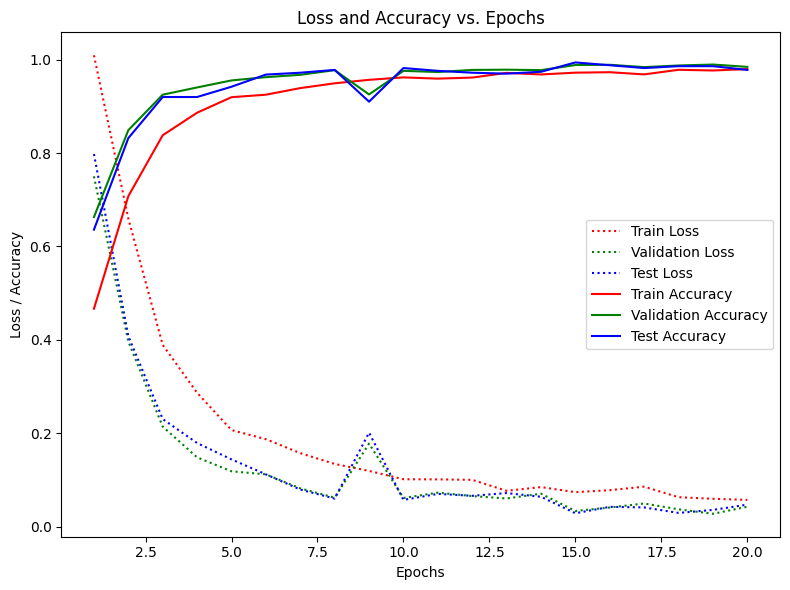

In [15]:
# Experiment 2: Change Activation Function
model_exp2 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.LeakyReLU(inplace=True),  # Change activation function
    nn.Linear(100, 3),
)

optimizer_exp2 = optim.SGD(model_exp2.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp2, loss_func, optimizer_exp2, train_dl, valid_dl, test_dl)

### Experiment 3
In this experiment, we change the learning rate used for training the model. The learning rate determines the step size at which the model updates its parameters during the optimization process. By adjusting the learning rate, we can explore its effect on the convergence speed and the overall performance of the model.

  5%|▌         | 1/20 [00:11<03:35, 11.36s/it]

EPOCH: 01/20 LOSS: 1.0862 ACC: 0.3819  VAL-LOSS: 1.0248 VAL-ACC: 0.5085  TEST-LOSS: 1.0207 TEST-ACC: 0.4920 


 10%|█         | 2/20 [00:22<03:23, 11.33s/it]

EPOCH: 02/20 LOSS: 0.9035 ACC: 0.5773  VAL-LOSS: 0.7383 VAL-ACC: 0.6840  TEST-LOSS: 0.7473 TEST-ACC: 0.6700 


 15%|█▌        | 3/20 [00:33<03:12, 11.30s/it]

EPOCH: 03/20 LOSS: 0.6976 ACC: 0.6911  VAL-LOSS: 0.5649 VAL-ACC: 0.7685  TEST-LOSS: 0.5777 TEST-ACC: 0.7520 


 20%|██        | 4/20 [00:45<03:01, 11.32s/it]

EPOCH: 04/20 LOSS: 0.5643 ACC: 0.7621  VAL-LOSS: 0.4900 VAL-ACC: 0.8020  TEST-LOSS: 0.4822 TEST-ACC: 0.8000 


 25%|██▌       | 5/20 [00:56<02:49, 11.30s/it]

EPOCH: 05/20 LOSS: 0.4713 ACC: 0.8017  VAL-LOSS: 0.4271 VAL-ACC: 0.8355  TEST-LOSS: 0.4169 TEST-ACC: 0.8300 


 30%|███       | 6/20 [01:07<02:37, 11.28s/it]

EPOCH: 06/20 LOSS: 0.4151 ACC: 0.8275  VAL-LOSS: 0.3778 VAL-ACC: 0.8555  TEST-LOSS: 0.3794 TEST-ACC: 0.8440 


 35%|███▌      | 7/20 [01:19<02:26, 11.29s/it]

EPOCH: 07/20 LOSS: 0.3540 ACC: 0.8596  VAL-LOSS: 0.3437 VAL-ACC: 0.8565  TEST-LOSS: 0.3357 TEST-ACC: 0.8500 


 40%|████      | 8/20 [01:30<02:15, 11.31s/it]

EPOCH: 08/20 LOSS: 0.3175 ACC: 0.8729  VAL-LOSS: 0.3094 VAL-ACC: 0.8785  TEST-LOSS: 0.2985 TEST-ACC: 0.8820 


 45%|████▌     | 9/20 [01:41<02:04, 11.31s/it]

EPOCH: 09/20 LOSS: 0.2858 ACC: 0.8885  VAL-LOSS: 0.2812 VAL-ACC: 0.8930  TEST-LOSS: 0.2738 TEST-ACC: 0.8940 


 50%|█████     | 10/20 [01:53<01:53, 11.31s/it]

EPOCH: 10/20 LOSS: 0.2570 ACC: 0.8959  VAL-LOSS: 0.2834 VAL-ACC: 0.8850  TEST-LOSS: 0.2585 TEST-ACC: 0.8900 


 55%|█████▌    | 11/20 [02:04<01:41, 11.32s/it]

EPOCH: 11/20 LOSS: 0.2422 ACC: 0.9072  VAL-LOSS: 0.2668 VAL-ACC: 0.8945  TEST-LOSS: 0.2518 TEST-ACC: 0.8920 


 60%|██████    | 12/20 [02:15<01:30, 11.30s/it]

EPOCH: 12/20 LOSS: 0.2226 ACC: 0.9128  VAL-LOSS: 0.2505 VAL-ACC: 0.8990  TEST-LOSS: 0.2376 TEST-ACC: 0.8980 


 65%|██████▌   | 13/20 [02:26<01:19, 11.29s/it]

EPOCH: 13/20 LOSS: 0.2145 ACC: 0.9140  VAL-LOSS: 0.2300 VAL-ACC: 0.9050  TEST-LOSS: 0.2338 TEST-ACC: 0.9100 


 70%|███████   | 14/20 [02:38<01:07, 11.28s/it]

EPOCH: 14/20 LOSS: 0.1929 ACC: 0.9244  VAL-LOSS: 0.2369 VAL-ACC: 0.9055  TEST-LOSS: 0.2294 TEST-ACC: 0.9140 


 75%|███████▌  | 15/20 [02:49<00:56, 11.28s/it]

EPOCH: 15/20 LOSS: 0.1859 ACC: 0.9267  VAL-LOSS: 0.2199 VAL-ACC: 0.9100  TEST-LOSS: 0.2154 TEST-ACC: 0.9200 


 80%|████████  | 16/20 [03:00<00:45, 11.27s/it]

EPOCH: 16/20 LOSS: 0.1730 ACC: 0.9351  VAL-LOSS: 0.2124 VAL-ACC: 0.9115  TEST-LOSS: 0.2193 TEST-ACC: 0.9200 


 85%|████████▌ | 17/20 [03:12<00:33, 11.28s/it]

EPOCH: 17/20 LOSS: 0.1664 ACC: 0.9319  VAL-LOSS: 0.1939 VAL-ACC: 0.9220  TEST-LOSS: 0.1970 TEST-ACC: 0.9260 


 90%|█████████ | 18/20 [03:23<00:22, 11.26s/it]

EPOCH: 18/20 LOSS: 0.1528 ACC: 0.9419  VAL-LOSS: 0.1974 VAL-ACC: 0.9260  TEST-LOSS: 0.1835 TEST-ACC: 0.9320 


 95%|█████████▌| 19/20 [03:34<00:11, 11.28s/it]

EPOCH: 19/20 LOSS: 0.1434 ACC: 0.9437  VAL-LOSS: 0.1818 VAL-ACC: 0.9335  TEST-LOSS: 0.1992 TEST-ACC: 0.9240 


100%|██████████| 20/20 [03:45<00:00, 11.30s/it]

EPOCH: 20/20 LOSS: 0.1471 ACC: 0.9421  VAL-LOSS: 0.1835 VAL-ACC: 0.9260  TEST-LOSS: 0.1945 TEST-ACC: 0.9220 


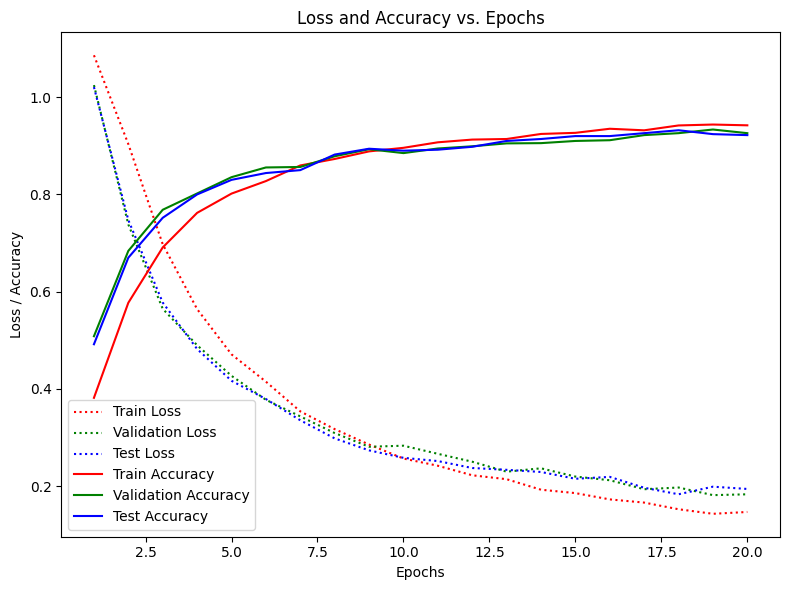

In [16]:
# Experiment 3: Adjust Learning Rate
lr_exp3 = 0.01  # Change learning rate

model_exp3 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

optimizer_exp3 = optim.SGD(model_exp3.parameters(), lr=lr_exp3, momentum=0.9)

fit(epochs, model_exp3, loss_func, optimizer_exp3, train_dl, valid_dl, test_dl)

# Task 2: Carpet Matching 

In [17]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [18]:
from sklearn.metrics import pairwise_distances
import torch
import torch.nn as nn
import torch.optim as optim

def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0

    queries_np = queries.cpu().numpy()
    targets_np = targets.cpu().numpy()

    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries_np[i][None]).float().to(device)
        t = torch.from_numpy(targets_np[i]).float().to(device)

        with torch.no_grad():
            emb_q = model(q).cpu().numpy()
            emb_t = model(t).cpu().numpy()

            dists = pairwise_distances(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1

    return 100 * cnt / gt.shape[0]

In [19]:
# class CarpetMatchingModel(nn.Module):
#     def __init__(self, num_classes):
#         super(CarpetMatchingModel, self).__init__()
#         # Define your model architecture here
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
#         self.relu2 = nn.ReLU()
#         self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
#         self.relu3 = nn.ReLU()
#         self.avgpool = nn.AvgPool2d(4)
#         self.flatten = nn.Flatten()
#         self.linear = nn.Linear(60, num_classes)
#
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.avgpool(x)
#         x = self.flatten(x)
#         x = self.linear(x)
#         return x
#
class CarpetMatchingModel(nn.Module):
    def __init__(self, num_classes):
        super(CarpetMatchingModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(23040, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
model = CarpetMatchingModel(num_classes=200)
loss_func = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the numpy arrays to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()
queries_tensor = torch.from_numpy(queries).float()
targets_tensor = torch.from_numpy(targets).float()

# Set the device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)
queries_tensor = queries_tensor.to(device)
targets_tensor = targets_tensor.to(device)

EPOCH: 001/100 LOSS: 5.3177 ACC: 0.0052 
EPOCH: 002/100 LOSS: 5.3111 ACC: 0.0063 
EPOCH: 003/100 LOSS: 5.3095 ACC: 0.0055 
EPOCH: 004/100 LOSS: 5.3066 ACC: 0.0063 
EPOCH: 005/100 LOSS: 5.3079 ACC: 0.0066 
EPOCH: 006/100 LOSS: 5.3058 ACC: 0.0069 
EPOCH: 007/100 LOSS: 5.3024 ACC: 0.0067 
EPOCH: 008/100 LOSS: 5.3026 ACC: 0.0071 
EPOCH: 009/100 LOSS: 5.3003 ACC: 0.0077 
EPOCH: 010/100 LOSS: 5.2959 ACC: 0.0068 
EPOCH: 011/100 LOSS: 5.2918 ACC: 0.0078 
EPOCH: 012/100 LOSS: 5.2844 ACC: 0.0093 
EPOCH: 013/100 LOSS: 5.2510 ACC: 0.0125 
EPOCH: 014/100 LOSS: 5.1339 ACC: 0.0203 
EPOCH: 015/100 LOSS: 4.8351 ACC: 0.0450 
EPOCH: 016/100 LOSS: 4.3806 ACC: 0.0931 
EPOCH: 017/100 LOSS: 3.9659 ACC: 0.1452 
EPOCH: 018/100 LOSS: 3.5978 ACC: 0.1992 
EPOCH: 019/100 LOSS: 3.2874 ACC: 0.2448 
EPOCH: 020/100 LOSS: 2.9858 ACC: 0.2982 
EPOCH: 021/100 LOSS: 2.8599 ACC: 0.3203 
EPOCH: 022/100 LOSS: 2.6784 ACC: 0.3635 
EPOCH: 023/100 LOSS: 2.4845 ACC: 0.3991 
EPOCH: 024/100 LOSS: 2.3323 ACC: 0.4287 
EPOCH: 025/100 L

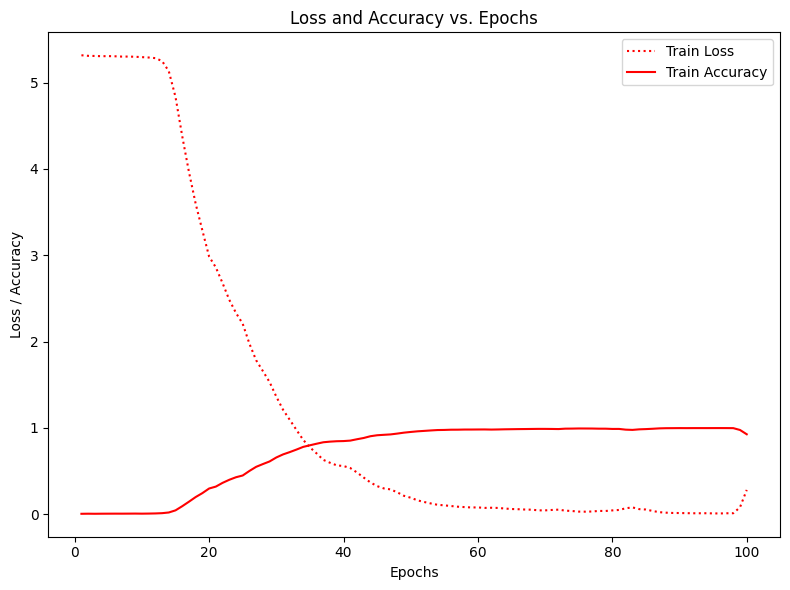

CarpetMatchingModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=200, bias=True)
)

In [21]:
num_epochs = 100
batch_size = 64

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Mini-batch training
    for i in range(0, X_tensor.size(0), batch_size):
        inputs = X_tensor[i:i+batch_size]
        labels = y_tensor[i:i+batch_size]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_func(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store the average loss and accuracy for the epoch
    train_loss = running_loss / (X_tensor.size(0) / batch_size)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Print the average loss and accuracy for the epoch
    print(f'EPOCH: {epoch+1:0>{len(str(num_epochs))}}/{num_epochs}', end=' ')
    print(f'LOSS: {train_loss:.4f}', f'ACC: {train_accuracy:.4f} ', end='\n')

# Plot losses and accuracies
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, 'r:', label='Train Loss')
plt.plot(range(1, num_epochs+1), train_accuracies, 'r', label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Loss and Accuracy vs. Epochs')
plt.legend()
plt.tight_layout()
plt.show()

model.eval()

In [22]:
top_1_accuracy = query_performance(queries_tensor, targets_tensor, gt, top=1)
print(f'top-1 accuracy: {top_1_accuracy:.2f}%')
top_2_accuracy = query_performance(queries_tensor, targets_tensor, gt, top=2)
print(f'top-2 accuracy: {top_2_accuracy:.2f}%')
top_3_accuracy = query_performance(queries_tensor, targets_tensor, gt, top=3)
print(f'top-3 accuracy: {top_3_accuracy:.2f}%')

top-1 accuracy: 18.00%
top-2 accuracy: 40.33%
top-3 accuracy: 70.67%
